# Replication of Avellaneda & Lee (2008) PCA Statistical Arbitrage Strategy

This notebook implements the Avellaneda and Lee PCA statistical arbitrage strategy. Implementation choices and practical deviations from the original paper - driven by available data, survivorship bias, and pragmatic execution considerations - are documented below. The goal is to demonstrate a reproducible backtest pipeline and sensitivity to key hyperparameters (e.g., transaction costs and number of principal components).

## Data, Universe Construction, and Core Assumptions

**Trading Universe:**
- All as-of-date (mid-2025) Russell 1000 constituents are used; the list is scrapped from Wikipedia page for Russell 1000. This introduces survivorship bias, and the effective universe size is materially smaller than in the original paper, especially in earlier years.

**Size Filter:**
- Stocks with market capitalization below \$1 billion on the trade date close are excluded.

**Price Data:**
- Daily OHLCV data fetched from yfinance. Shares outstanding manually computed. Daily adjusted close prices are used for signal generation. The actual data fetching and processing scripts can be found in `yf_download.py` and `build_gold_csv.py`.

**Signal & Execution Timing:**
- Signals are computed using information up to and including day *t*'s close. Trades are executed at that same close price.

**Position Sizing & Hedging:**
- On day *t*, a fixed proportion (`leverage_level`, default 2\%) of portfolio equity is allocated per stock with a signal. For example, with \\$100,000 equity and 10 assets in the universe, each long/short exposure is \\$2,000, with corresponding hedging done via PCA factors.
- The hedge is constructed once per signal (following the paper): after signal generation, hedge exposures are held constant until the next signal trigger to avoid frequent rebalancing, even though underlying factor exposures change.

**Capital & Estimation Windows:**
- Initial capital: \$100,000.
- PCA estimation window: 252 trading days.
- AR(1) window for cumulative residuals: 60 days.
- Number of PCA factors: baseline 15 (with sensitivity analysis at 5).


## Backtest Configuration and Baseline Experiments

Below we illustrate two baseline configurations to understand frictionless performance.

### Zero Transaction Cost Baseline
- Transaction cost set to zero.

In [1]:
from AvellanedaLee.src.main import *
from dataclasses import asdict
import matplotlib.pyplot as plt

In [2]:
rets_path=Path("../../data_lake/gold/russell1000/adjclose_wide.csv")
mc_path=Path("../../data_lake/gold/russell1000/marketcap_wide.csv")
rets, mc = load_data(rets_path, mc_path)
end_date = "2007-12-31"
rets, mc = rets.loc[:end_date], mc.loc[:end_date]
cfg = ALConfig()
cfg.t_cost = 0.0
print("Backtester Configuration:")
for k, v in asdict(cfg).items():
    print(f"{k}: {v}")

Backtester Configuration:
pca_win: 252
lookback_ou: 60
n_pcs: 15
s_bo: 1.25
s_so: 1.25
s_sc: 0.5
s_bc: 0.75
b_max: 0.9672
min_universe: 70
leverage_level: 0.02
t_cost: 0.0
start_capital: 100000.0
mc_floor: 1000000000.0


In [3]:
portfolio_zeroTC = backtest_loop(rets, mc, cfg)
performance_zeroTC = perf_metrics(portfolio_zeroTC.equity.dropna())

backtest loop:   0%|          | 0/2514 [00:00<?, ?it/s]


--- Performance (Equity-Based) ---
Sharpe Ratio: 2.10
Maximum Drawdown: -9.95%


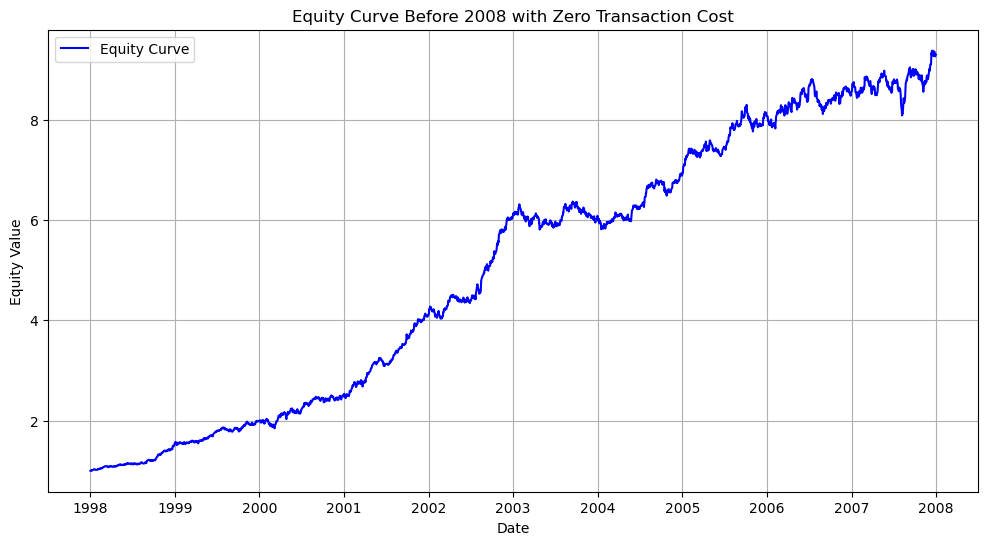

In [4]:
plt.figure(figsize=(12, 6))
plt.plot((performance_zeroTC['daily_return']+1).cumprod(), label='Equity Curve', color='blue')
plt.title('Equity Curve Before 2008 with Zero Transaction Cost')
plt.xlabel('Date')
plt.ylabel('Equity Value')
plt.legend()
plt.grid()
plt.show()

### 5 Basis Points Transaction Cost
- Introduce a realistic execution friction: 5 bps per trade.

In [5]:
cfg.t_cost = 0.0005

In [6]:
portfolio_5bps = backtest_loop(rets, mc, cfg)
performance_5bps = perf_metrics(portfolio_5bps.equity.dropna())

backtest loop:   0%|          | 0/2514 [00:00<?, ?it/s]


--- Performance (Equity-Based) ---
Sharpe Ratio: 0.45
Maximum Drawdown: -48.68%


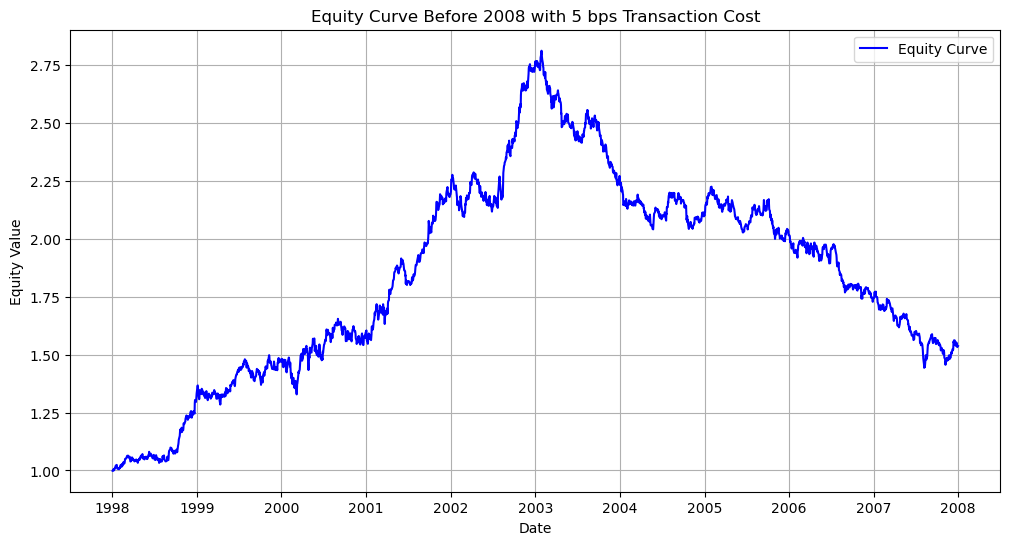

In [7]:
plt.figure(figsize=(12, 6))
plt.plot((performance_5bps['daily_return']+1).cumprod(), label='Equity Curve', color='blue')
plt.title('Equity Curve Before 2008 with 5 bps Transaction Cost')
plt.xlabel('Date')
plt.ylabel('Equity Value')
plt.legend()
plt.grid()
plt.show()

## Remarks and Sensitivity

- The strategy’s realized performance is lower than that reported in the original study. The primary drivers are likely the **survivorship bias  and smaller universe**: Using mid-2025 Russell 1000 constituents throughout backtest history shrinks the early-period universe relative to the original.

- Performance is materially stronger in the pre-2003 period, consistent with the original paper’s qualitative findings.

- **Sensitivity analysis:** Reducing the number of retained PCA components from 15 to 5 improves performance under 5 bps transaction costs, suggesting overfitting and/or noise inclusion when too many components are retained in a constrained universe. The sharper drawdown in 2007 becomes more prominent, again aligning with known behaviors from the original paper

In [8]:
# Using 5 PCA factors instead of 15
cfg.n_pcs = 5
portfolio_5bps_5factors = backtest_loop(rets, mc, cfg)
performance_5bps_5factors = perf_metrics(portfolio_5bps_5factors.equity.dropna())

backtest loop:   0%|          | 0/2514 [00:00<?, ?it/s]


--- Performance (Equity-Based) ---
Sharpe Ratio: 0.84
Maximum Drawdown: -36.73%


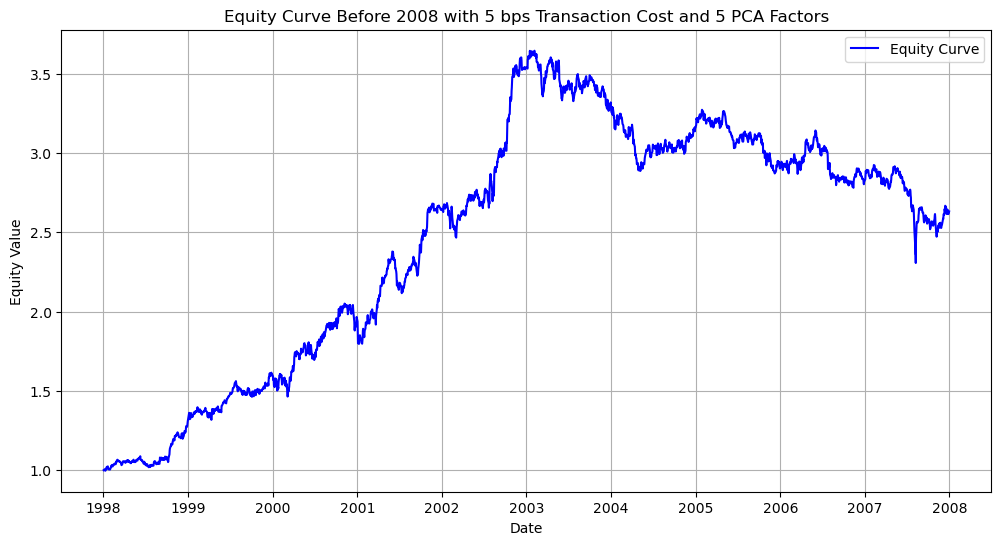

In [9]:
plt.figure(figsize=(12, 6))
plt.plot((performance_5bps_5factors['daily_return'] + 1).cumprod(), label='Equity Curve', color='blue')
plt.title('Equity Curve Before 2008 with 5 bps Transaction Cost and 5 PCA Factors')
plt.xlabel('Date')
plt.ylabel('Equity Value')
plt.legend()
plt.grid()
plt.show()